## 📄 Importing libraries to use for eda and model training

In [26]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
import joblib 
import streamlit as st

## 📄 Dataset Feature Descriptions

- **`step`**: Represents a unit of time in the real world, with 1 step equating to 1 hour. The total simulation spans 744 steps, equivalent to 30 days.
- **`type`**: Transaction types include `CASH-IN`, `CASH-OUT`, `DEBIT`, `PAYMENT`, and `TRANSFER`.
- **`amount`**: The transaction amount in the local currency.
- **`nameOrig`**: The customer initiating the transaction.
- **`oldbalanceOrg`**: The initial balance before the transaction.
- **`newbalanceOrig`**: The new balance after the transaction.
- **`nameDest`**: The transaction's recipient customer.
- **`oldbalanceDest`**: The initial recipient's balance before the transaction. Not applicable for customers identified by `'M'` (Merchants).
- **`newbalanceDest`**: The new recipient's balance after the transaction. Not applicable for `'M'` (Merchants).
- **`isFraud`**: Identifies transactions conducted by fraudulent agents aiming to deplete customer accounts through transfers.


In [27]:
df = pd.read_csv('fraud_detection.csv')
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
1048570,95,CASH_OUT,132557.35,C1179511630,479803.00,347245.65,C435674507,484329.37,616886.72,0
1048571,95,PAYMENT,9917.36,C1956161225,90545.00,80627.64,M668364942,0.00,0.00,0
1048572,95,PAYMENT,14140.05,C2037964975,20545.00,6404.95,M1355182933,0.00,0.00,0
1048573,95,PAYMENT,10020.05,C1633237354,90605.00,80584.95,M1964992463,0.00,0.00,0


## 📄 Dropping ID columns 

In [28]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [29]:
print(df.shape)
df.head()
df.describe()
df.info()

(1048575, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   oldbalanceOrg   1048575 non-null  float64
 4   newbalanceOrig  1048575 non-null  float64
 5   oldbalanceDest  1048575 non-null  float64
 6   newbalanceDest  1048575 non-null  float64
 7   isFraud         1048575 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 64.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  flo

In [30]:
df.isnull().sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

Text(0.5, 1.0, 'Fraud vs Non-Fraud Distribution')

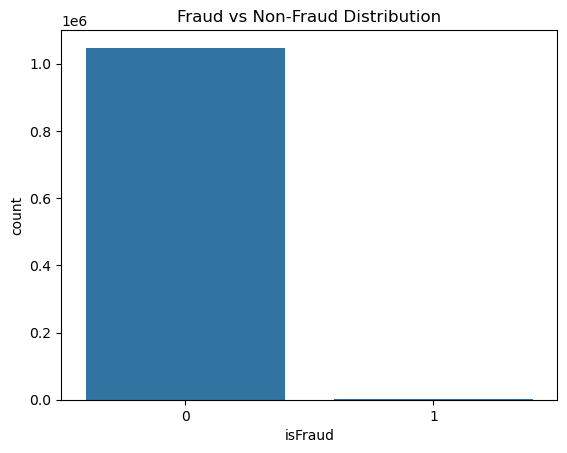

In [31]:
sns.countplot(x='isFraud', data=df)
plt.title('Fraud vs Non-Fraud Distribution')

In [32]:
fraud_ratio = df['isFraud'].mean()
print(f"Fraudulent transaction ratio: {fraud_ratio:.4f}")

Fraudulent transaction ratio: 0.0011


Text(0.5, 1.0, 'Transaction Type vs Fraudulent Transactions')

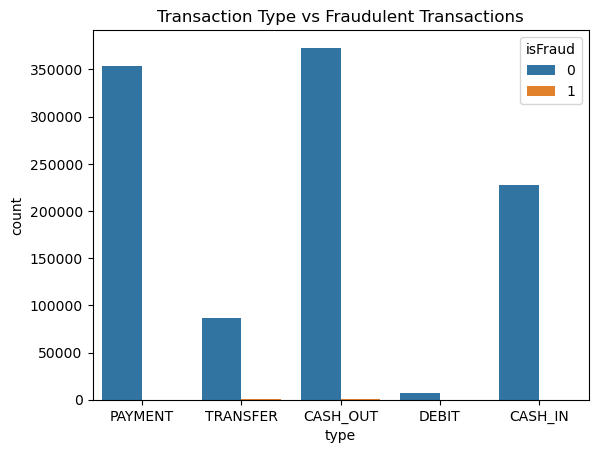

In [33]:
sns.countplot(x='type', hue='isFraud', data=df)
plt.title('Transaction Type vs Fraudulent Transactions')


Text(0.5, 1.0, 'Transaction Amounts by Fraud Label')

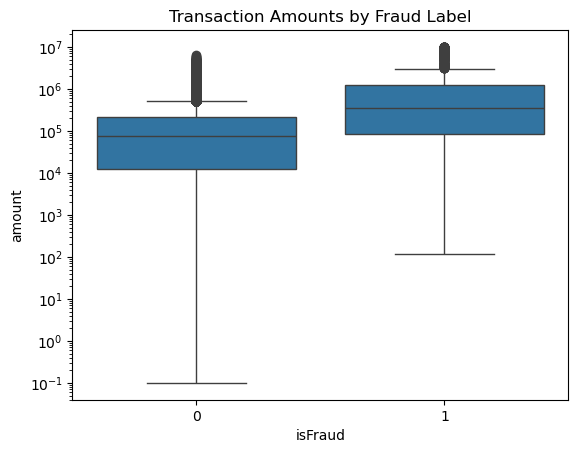

In [34]:
sns.boxplot(x='isFraud', y='amount', data=df)
plt.yscale('log')
plt.title('Transaction Amounts by Fraud Label')

<Axes: xlabel='balance_change', ylabel='Count'>

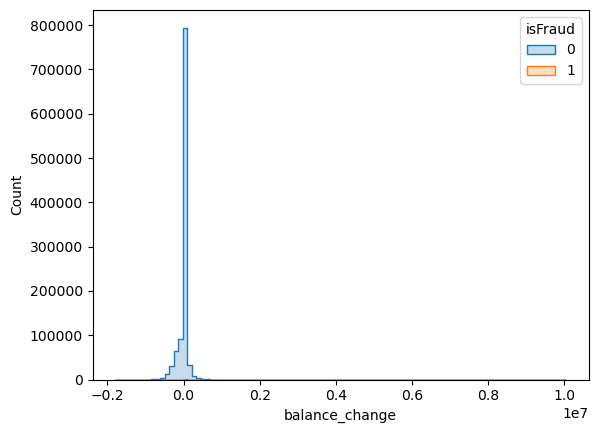

In [35]:
# Example: zero outgoing balance despite transaction
df['balance_change'] = df['oldbalanceOrg'] - df['newbalanceOrig']
sns.histplot(data=df, x='balance_change', hue='isFraud', bins=100, element='step')


Text(0.5, 1.0, 'Feature Correlation Matrix')

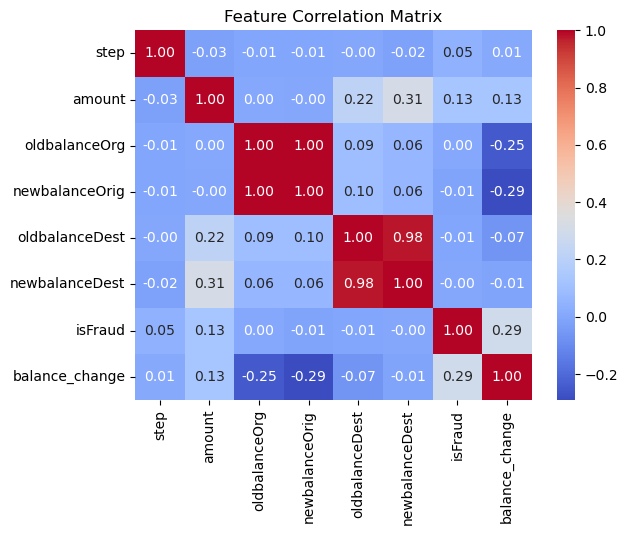

In [36]:
import numpy as np

corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')


In [37]:
from sklearn.utils import resample

df_majority = df[df.isFraud == 0]
df_minority = df[df.isFraud == 1]

df_majority_downsampled = resample(df_majority, 
                                   replace=False,     
                                   n_samples=len(df_minority)*5,  # e.g., 5:1 ratio
                                   random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])


In [38]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [39]:
from imblearn.over_sampling import SMOTE

X = df.drop('isFraud', axis=1)
y = df['isFraud']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('isFraud', axis=1))

In [41]:
from sklearn.model_selection import train_test_split

X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

df


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balance_change,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,9839.64,False,False,True,False
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,1864.28,False,False,True,False
2,1,181.00,181.00,0.00,0.00,0.00,1,181.00,False,False,False,True
3,1,181.00,181.00,0.00,21182.00,0.00,1,181.00,True,False,False,False
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,11668.14,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,95,132557.35,479803.00,347245.65,484329.37,616886.72,0,132557.35,True,False,False,False
1048571,95,9917.36,90545.00,80627.64,0.00,0.00,0,9917.36,False,False,True,False
1048572,95,14140.05,20545.00,6404.95,0.00,0.00,0,14140.05,False,False,True,False
1048573,95,10020.05,90605.00,80584.95,0.00,0.00,0,10020.05,False,False,True,False


In [42]:
# 📦 Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 📊 Dictionary to hold models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

In [43]:
for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # for ROC AUC

    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    auc = roc_auc_score(y_test, y_prob)
    print(f"ROC AUC Score: {auc:.4f}")


===== Logistic Regression =====
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.90      0.39      0.55       228

    accuracy                           1.00    209715
   macro avg       0.95      0.70      0.77    209715
weighted avg       1.00      1.00      1.00    209715

ROC AUC Score: 0.9784

===== Random Forest =====
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.90      0.39      0.55       228

    accuracy                           1.00    209715
   macro avg       0.95      0.70      0.77    209715
weighted avg       1.00      1.00      1.00    209715

ROC AUC Score: 0.9784

===== Random Forest =====
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.99      0.76    

c:\Users\desyt\anaconda3\envs\mldp\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:47:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.90      0.80      0.84       228

    accuracy                           1.00    209715
   macro avg       0.95      0.90      0.92    209715
weighted avg       1.00      1.00      1.00    209715

ROC AUC Score: 0.9957

===== LightGBM =====
[LightGBM] [Info] Number of positive: 914, number of negative: 837946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1612
[LightGBM] [Info] Number of data points in the train set: 838860, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001090 -> initscore=-6.820878
[LightGBM] [Info] Start training from score -6.820878
[LightGBM] [Info] Number of positive: 914, numbe

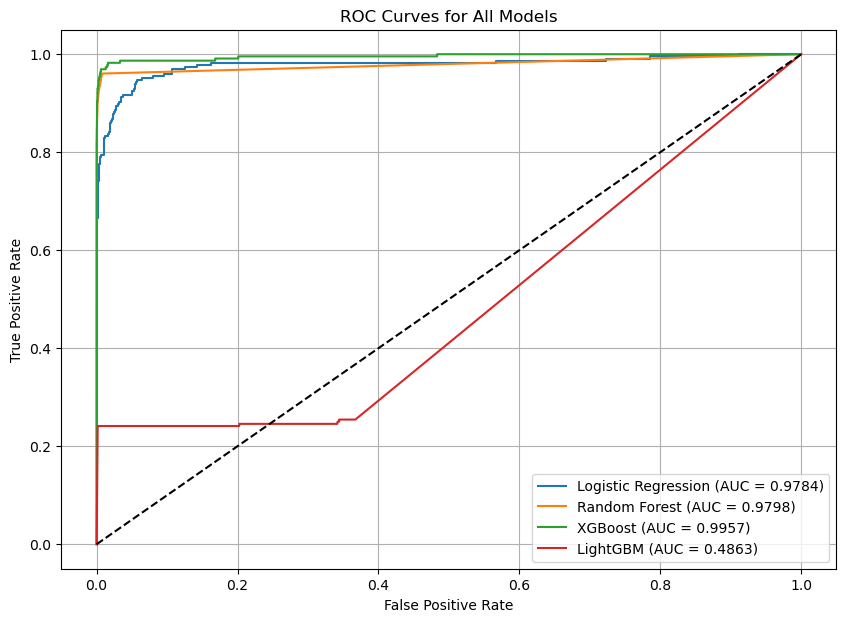

In [44]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 7))

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.4f})")

plt.plot([0, 1], [0, 1], 'k--')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend()
plt.grid()
plt.show()


In [45]:
X

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,balance_change,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.00,160296.36,0.00,0.00,9839.64,False,False,True,False
1,1,1864.28,21249.00,19384.72,0.00,0.00,1864.28,False,False,True,False
2,1,181.00,181.00,0.00,0.00,0.00,181.00,False,False,False,True
3,1,181.00,181.00,0.00,21182.00,0.00,181.00,True,False,False,False
4,1,11668.14,41554.00,29885.86,0.00,0.00,11668.14,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
1048570,95,132557.35,479803.00,347245.65,484329.37,616886.72,132557.35,True,False,False,False
1048571,95,9917.36,90545.00,80627.64,0.00,0.00,9917.36,False,False,True,False
1048572,95,14140.05,20545.00,6404.95,0.00,0.00,14140.05,False,False,True,False
1048573,95,10020.05,90605.00,80584.95,0.00,0.00,10020.05,False,False,True,False



🔎 Logistic Regression Feature Importance


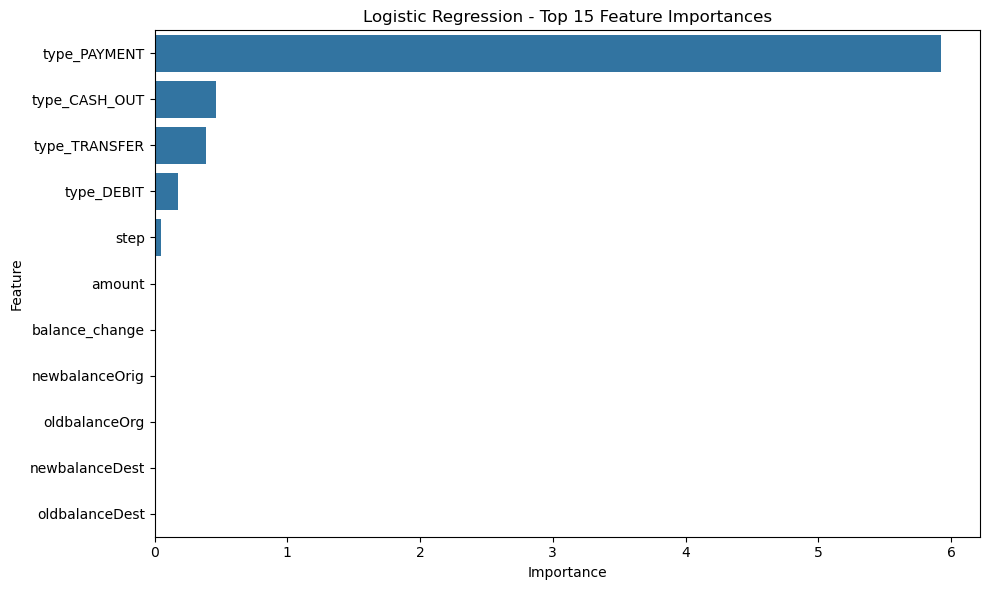


🔎 Random Forest Feature Importance


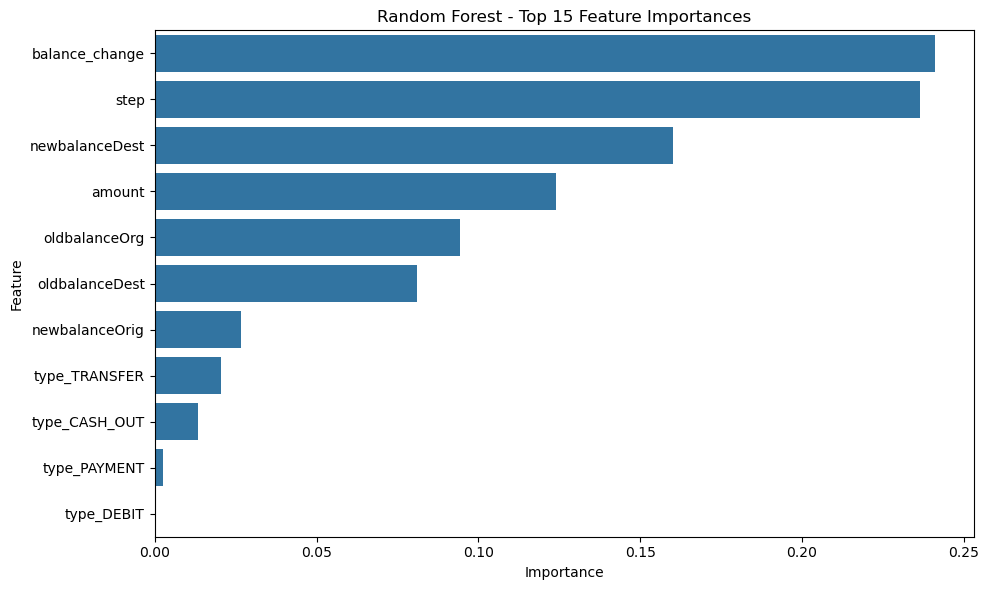


🔎 XGBoost Feature Importance


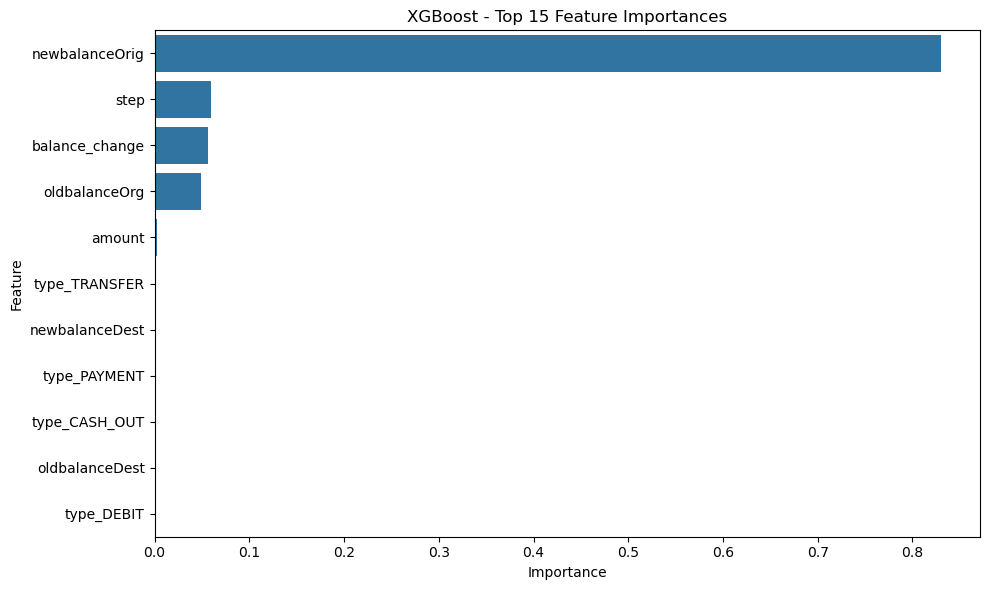


🔎 LightGBM Feature Importance


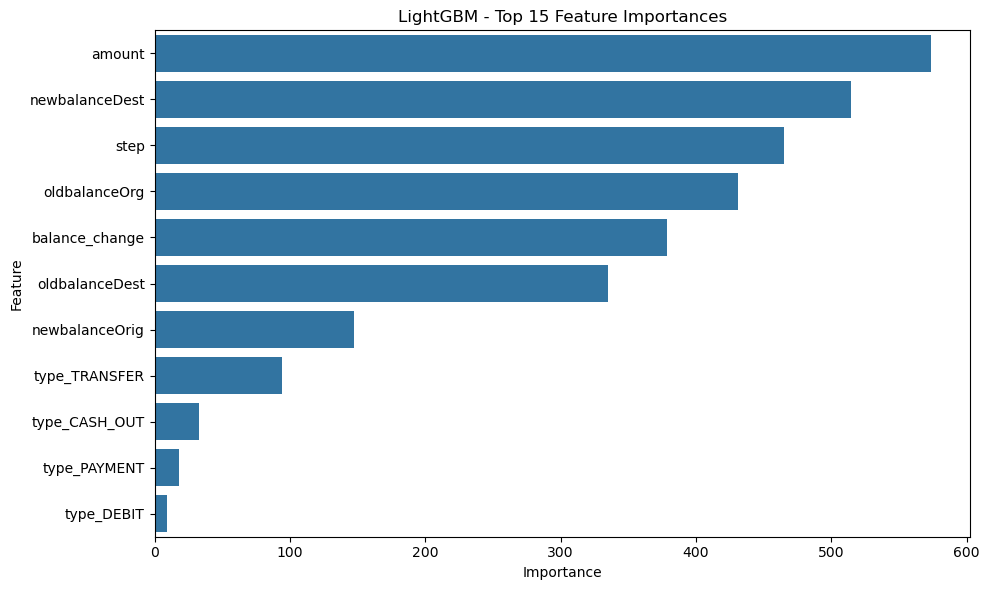

In [46]:
import pandas as pd
import seaborn as sns

def plot_feature_importance(model, X, model_name):
    if hasattr(model, 'feature_importances_'):
        # Tree-based models
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # Logistic Regression
        importances = model.coef_[0]
    else:
        print(f"No feature importance available for {model_name}")
        return

    features = X.columns
    fi_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    fi_df['Importance'] = fi_df['Importance'].abs()  # take absolute values for LR

    fi_df = fi_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=fi_df.head(15))
    plt.title(f'{model_name} - Top 15 Feature Importances')
    plt.tight_layout()
    plt.show()

# Plot feature importances for each model
for name, model in models.items():
    print(f"\n🔎 {name} Feature Importance")
    plot_feature_importance(model, X_train, name)


Remove Random Forest and Logistic Regression 

In [47]:
df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balance_change,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,9839.64,False,False,True,False
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,1864.28,False,False,True,False
2,1,181.00,181.00,0.00,0.00,0.00,1,181.00,False,False,False,True
3,1,181.00,181.00,0.00,21182.00,0.00,1,181.00,True,False,False,False
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,11668.14,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,95,132557.35,479803.00,347245.65,484329.37,616886.72,0,132557.35,True,False,False,False
1048571,95,9917.36,90545.00,80627.64,0.00,0.00,0,9917.36,False,False,True,False
1048572,95,14140.05,20545.00,6404.95,0.00,0.00,0,14140.05,False,False,True,False
1048573,95,10020.05,90605.00,80584.95,0.00,0.00,0,10020.05,False,False,True,False


In [50]:
import joblib

# Save the trained Random Forest model as model.pkl
joblib.dump(models["Random Forest"], "model.pkl")
# Save the scaler if used
joblib.dump(scaler, "scaler.joblib")
# Save columns order for input
import json
with open("model_columns.json", "w") as f:
    json.dump(list(X_train.columns), f)